# Interactive networks visualization and annotation

*tysserand* includes functions to help using [napari](https://napari.org/) for interactive image and network visualization and annotation.  
Thanks to napari you can zoom, pan and hide or change the intensity of individual channels.  
We define the ground truth of network of the multiplex Immuno Fluorescence image.  
We start with a Delaunay reconstruction, then we manually add and delete some edges.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [2]:
# If you haven't installed tysserand with pip, but you execute this tutorial from the downloaded project repo:
import sys
sys.path.extend(['../../tysserand']) # change directory accordingly

In [3]:
from tysserand import tysserand as ty

In [4]:
# where we save and load annotations
data_dir = Path("../data/mIF_WSI_tile")

## Delaunay triangulation

In [5]:
# With a small tissue network
img = plt.imread(data_dir / "tile.png")

We first load existing nodes annotations. For each cell type we define a node color, then we define a first version of edges with the delaunay triangulation method.

In [6]:
nodes = pd.read_csv(data_dir / "nodes_v1.csv", usecols=['x','y', 'marker'])

coords = nodes.loc[:,['x','y']].values
pairs = ty.build_delaunay(coords)
distances = ty.distance_neighbors(coords, pairs)

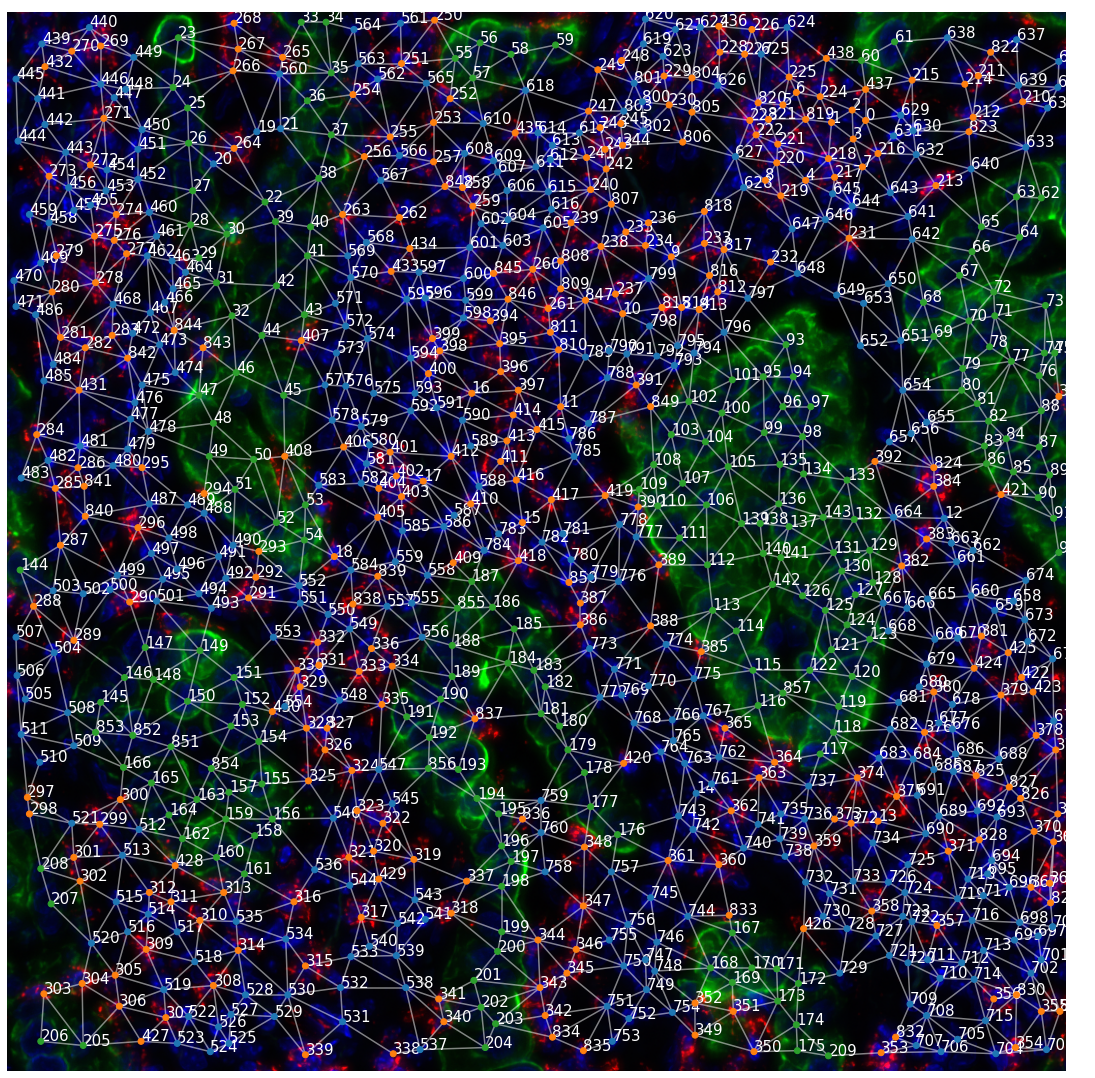

In [16]:
# make colors for nodes
#                 orange      blue      green
class_colors = ['#ff7f0e', '#1f77b4', '#2ca02c']
classes = list(nodes['marker'].unique())
dico_col = {classes[0]:class_colors[0],
            classes[1]:class_colors[1],
            classes[2]:class_colors[2]}
colors = []
for cl in nodes['marker']:
    colors.append(dico_col[cl])
    
# superimpose network to mIF image
fig, ax = ty.showim(img, figsize=(15, 15))
ty.plot_network(coords, pairs, col_nodes=colors, col_edges='w', ax=ax)

for i, (x,y) in enumerate(coords):
    text = str(i)
    plt.text(x, y, text, fontdict={'c':'white', 'fontsize':15})

## Napari-assisted annotations

We use napari to hide channels or tweak their intensity. In the viewer we can add, move or delete points and edges that will be considered as nodes by *tysserand*. These data are stores as a `dictionnary` of annotations.

In [8]:
import napari

We load napari with independent layers for each channel:

In [9]:
viewer = napari.Viewer()
ty.visualize(viewer, img, colormaps='rgb')

/home/alexis/.cache/pypoetry/virtualenvs/tysserand-oc5OK4VF-py3.8/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


We add nodes positions as annotations:

nodes_coords: nb_nodes x 2 array  
edges_coords: list of 2 x 2 arrays of length nb_edges

In [10]:
# make colors for nodes
#                 orange      blue      green
class_colors = ['#ff7f0e', '#1f77b4', '#2ca02c']
classes = list(nodes['marker'].unique())
dico_col = {classes[0]:class_colors[0],
            classes[1]:class_colors[1],
            classes[2]:class_colors[2]}

    
annotations = ty.make_annotation_dict(
    coords, pairs=pairs,
    nodes_class=nodes['marker'],
    nodes_class_color_mapper=dico_col,
)

In [11]:
ty.add_annotations(viewer, annotations)

Now you can inspect annotations and manually remove, modify or add nodes and edges.  
Select the right layer first (nodes or edges), and if you want to add nodes, select the apropriate `face color` that will be considered as a cell type indication. To do so select first an existing node with the desired color and copy the color code before creating a new node.

If you have added edges, to match their manually defined positions to their respective nodes and exact nodes positions *tysserand* provides an utility:

In [12]:
# get annotation layers names
layer_nodes_name, layer_edges_name = ty.get_annotation_names(viewer)
# get modified annotations
annotations = ty.get_annotation_dict(viewer, layer_nodes_name, layer_edges_name)
# clean edges positions
new_edges, pairs = ty.assign_nodes_to_edges(annotations['nodes_coords'], annotations['edges_coords'])
annotations['edges_coords'] = new_edges
annotations['pairs'] = pairs

You can now display the corrected edges with:

In [13]:
ty.update_edges(viewer, annotations)

You can finally save annotations with:

In [14]:
ty.save_annotations(data_dir / 'annotations.pkl', viewer=viewer)

If you want to reuse annotations:

In [15]:
annotations = ty.load_annotations(data_dir / 'annotations.pkl')

viewer = napari.Viewer()
ty.visualize(viewer, img, colormaps='rgb')
ty.add_annotations(viewer, annotations)

/home/alexis/.cache/pypoetry/virtualenvs/tysserand-oc5OK4VF-py3.8/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)
